# **ANALIZA FILMOVA I SERIJA NA NETFLIXU**

**Lucija Dumančić** 

## **Uvod**

Tema ovog projekta je analiza filmova i serija na Netflixu. [Skup podataka](https://www.kaggle.com/datasets/shivamb/netflix-shows) sadrži 8807 redaka i 12 stupaca. <br>
Stupci:
1.   **show_id**: jedinstveni ID za svaki film/TV emisiju
2.   **type**: film ili TV emisija
3.   **title**: naslov filma/TV emisije
4.    **director**: redatelj filma/TV emisije
5.    **cast**: glumačka postava u filmu/TV seriji
6.    **country**: zemlja gdje je film/TV emisija proizvedena
7.    **date_added**: datum dodavanja na Netflix
8.    **release_year**: godina objave filma/TV emisije
9.    **rating**: dobna skupina kojoj je film/TV emisija namijenjena
10.   **duration**: trajanje - u minutama ako je film ili u broju sezona ako je TV emisija
11.   **listed_in**: žanr
12.   **description**: sažeti opis

## **Priprema podataka**

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import scipy.stats as stats

from wordcloud import WordCloud, STOPWORDS

from nltk.parse.evaluate import unicodedata

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import string
string.punctuation

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
%cd /content/drive/MyDrive/UPZ/Projekt

/content/drive/MyDrive/UPZ/Projekt


In [3]:
data = pd.read_csv("netflix_titles.csv")

In [ ]:
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [4]:
print(f"Data shape: {data.shape}")
print("Columns:")
for col in data.columns:
  print("\t", col)

Data shape: (8807, 12)
Columns:
	 show_id
	 type
	 title
	 director
	 cast
	 country
	 date_added
	 release_year
	 rating
	 duration
	 listed_in
	 description


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


Nekim varijablama mijenjamo tip podatka kako bi poboljšali memorijsku učinkovitost. Varijable 'type', 'country', 'rating', 'duration', 'listed_in' mijenjamo u kategorički tip podatka. Varijablu 'release_year' mijenjamo u 'uint16' budući da se radi samo o četveroznamenkastom zapisu i nema potrebe za 'int64' tipom podatka. Varijablu 'date_added' mijenjamo u 'datetime64' zapis.

In [6]:
data['type'] = data['type'].astype('category')
data['country'] = data['country'].astype('category')

data['date_added'] = data['date_added'].astype('datetime64')

data['release_year'] = data['release_year'].astype('uint16')

data['rating'] = data['rating'].astype('category')
data['duration'] = data['duration'].astype('category')
data['listed_in'] = data['listed_in'].astype('category')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8807 non-null   object        
 1   type          8807 non-null   category      
 2   title         8807 non-null   object        
 3   director      6173 non-null   object        
 4   cast          7982 non-null   object        
 5   country       7976 non-null   category      
 6   date_added    8797 non-null   datetime64[ns]
 7   release_year  8807 non-null   uint16        
 8   rating        8803 non-null   category      
 9   duration      8804 non-null   category      
 10  listed_in     8807 non-null   category      
 11  description   8807 non-null   object        
dtypes: category(5), datetime64[ns](1), object(5), uint16(1)
memory usage: 551.8+ KB


In [8]:
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


**Provjera nedostajućih vrijednosti:**

In [9]:
na_values = data.isnull().sum()
percentage = data.isnull().sum()/data.shape[0]*100

value = {
    "na_values": na_values,
    "percentage": percentage
}
frame = pd.DataFrame(value)
frame

,na_values,percentage
show_id,0,0.000000
type,0,0.000000
title,0,0.000000
director,2634,29.908028
cast,825,9.367549
country,831,9.435676
date_added,10,0.113546
release_year,0,0.000000
rating,4,0.045418
duration,3,0.034064


Nedostajuće vrijednosti iz stupaca 'rating', 'duration' i 'date_added' ćemo ukloniti jer ih je malo.

In [10]:
data.dropna(subset = ["rating", "duration", "date_added"], axis=0, inplace=True)    

Nedostajuće vrijednosti u stupcima 'director' i 'cast' ćemo zamijentiti sa 'unknown', a nedostajuće vrijednosti u stupcu 'country' ćemo upotpuniti sa najčešćom vrijednosti koja se pojavljuje u tom stupcu.

In [11]:
data['director'].replace(np.NaN, "Unknown", inplace=True)
data['cast'].replace(np.NaN, "Unkown", inplace = True)
data['country'] =  data['country'].fillna(data['country'].mode()[0])

In [12]:
data.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

**Provjera duplikata:**

In [13]:
len(data[data.duplicated()])

0

Skup podataka nema dupliciranih podataka.

## **EDA**

In [14]:
data.describe()

,release_year
count,8790.000000
mean,2014.183163
std,8.825466
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


In [15]:
def plot_design():
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks(fontsize=15, color='black')
    plt.xticks(fontsize=15, color='black')
    plt.box(False)
    plt.tight_layout(pad=5.0)

### **Omjer filmova i TV emisija:**

Text(0.5, 1.0, 'Number of movies and TV shows on Netflix')

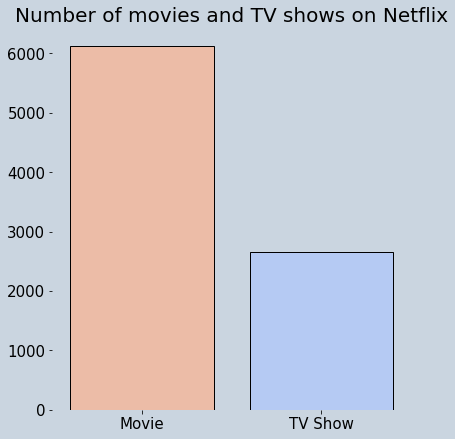

In [16]:
fig = plt.figure(figsize =(7, 7))
fig.patch.set_facecolor('#CAD5E0')

sns.countplot(x = data['type'], palette='coolwarm_r', edgecolor='black')
plot_design()
plt.title('Number of movies and TV shows on Netflix', fontsize=20)

<AxesSubplot:title={'center':'The ratio of movies and TV shows'}, ylabel='type'>

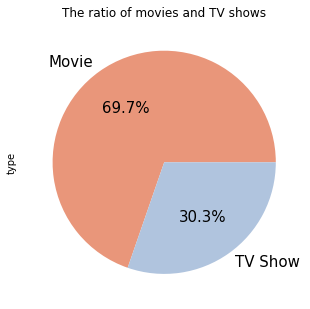

In [17]:
data['type'].value_counts().plot(kind = 'pie', title = 'The ratio of movies and TV shows', colors = ['darksalmon', 'lightsteelblue'], figsize= (5, 10), layout = (10, 2), autopct='%1.1f%%', fontsize=15)

In [18]:
print("69.7% ukupnog sadržaja na Netflixu čine filmovi, a preostalih 30.3% su TV emisije.")
print(f"Tako na Netflixu možemo pogledati {data['type'].value_counts()[0]} filmova te {data['type'].value_counts()[1]} TV emisije.")

69.7% ukupnog sadržaja na Netflixu čine filmovi, a preostalih 30.3% su TV emisije.
Tako na Netflixu možemo pogledati 6126 filmova te 2664 TV emisije.


### **Broj filmova i TV emisija objavljenih po godinama:**

Text(0.5, 1.0, 'Number of movies and TV shows released each year')

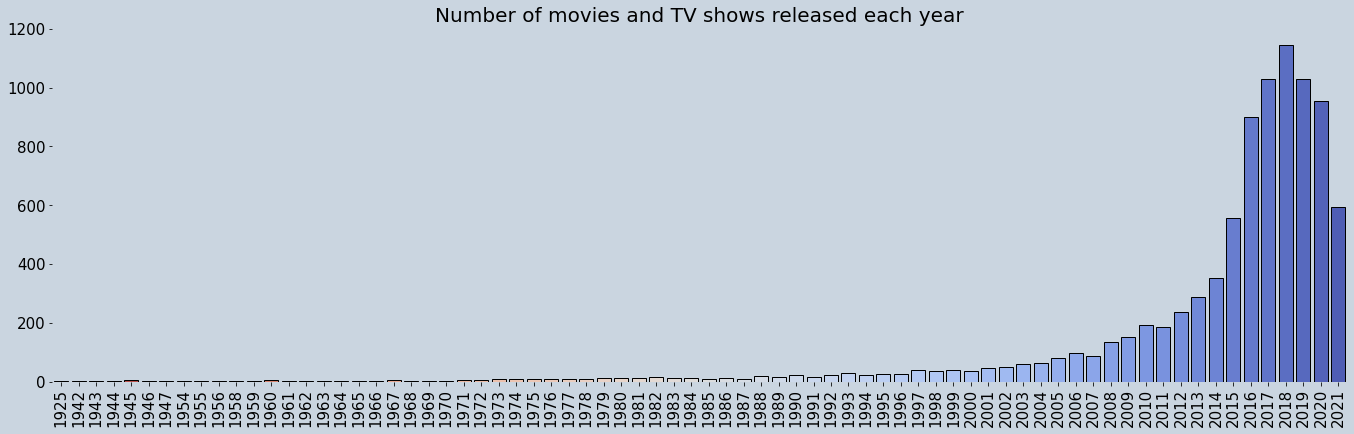

In [19]:
fig = plt.figure(figsize =(20, 7))
fig.patch.set_facecolor('#CAD5E0')

sns.countplot(x = data['release_year'], palette='coolwarm_r', edgecolor='black')
plt.xticks(rotation = 90)
plot_design()
plt.title('Number of movies and TV shows released each year', fontsize=20)

In [20]:
print(f"Godina sa najviše objavljenih filmova i TV emisija je {data['release_year'].value_counts().idxmax()}. sa {data['release_year'].value_counts().max()} objavom.")

Godina sa najviše objavljenih filmova i TV emisija je 2018. sa 1146 objavom.


In [21]:
data_group_type = data.groupby('type')
data_movie = data_group_type.get_group('Movie')
data_TVshow = data_group_type.get_group('TV Show')

Text(0.5, 1.0, 'Number of movies released each year')

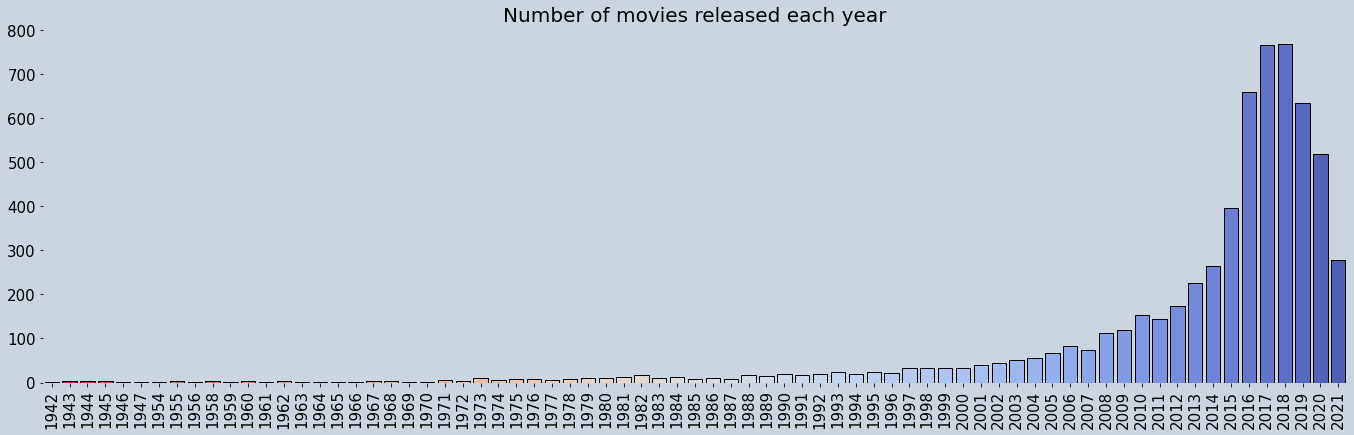

In [22]:
fig = plt.figure(figsize =(20, 7))
fig.patch.set_facecolor('#CAD5E0')

sns.countplot(x = data_movie['release_year'], data = data_movie,  palette='coolwarm_r', edgecolor='black')
plt.xticks(rotation = 90)
plot_design()
plt.title('Number of movies released each year', fontsize=20)

In [23]:
print(f"{data_movie['release_year'].value_counts().idxmax()}. godine je objavljeno najviše filmova, čak njih {data_movie['release_year'].value_counts().max()}.")

2018. godine je objavljeno najviše filmova, čak njih 767.


Text(0.5, 1.0, 'Number of TV shows released each year')

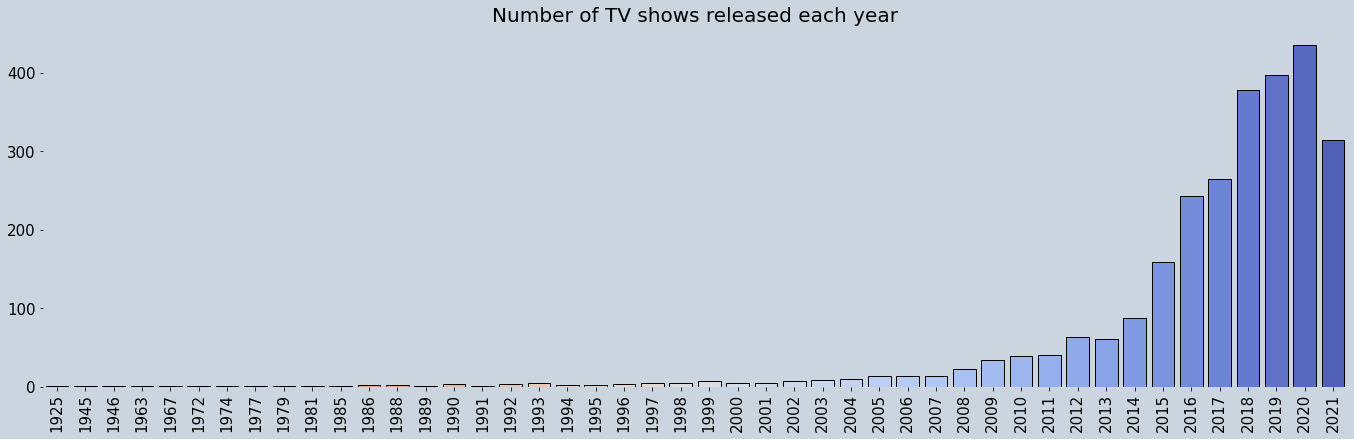

In [24]:
fig = plt.figure(figsize =(20, 7))
fig.patch.set_facecolor('#CAD5E0')

sns.countplot(x = data_TVshow['release_year'], data = data_TVshow,  palette='coolwarm_r', edgecolor='black')
plt.xticks(rotation = 90)
plot_design()
plt.title('Number of TV shows released each year', fontsize=20)

In [25]:
print(f"{data_TVshow['release_year'].value_counts().idxmax()}. godine je objavljeno {data_TVshow['release_year'].value_counts().max()} TV emisija, što je čini godinom s najviše objavljenih TV emisija.")

2020. godine je objavljeno 436 TV emisija, što je čini godinom s najviše objavljenih TV emisija.


### **10 najstarijih filmova i TV emisija:**

In [26]:
oldest_movie = data_movie.sort_values('release_year')[0:10]
oldest_movie[[ 'title', 'release_year']]

,title,release_year
7790,Prelude to War,1942
8205,The Battle of Midway,1942
8763,WWII: Report from the Aleutians,1943
8660,Undercover: How to Operate Behind Enemy Lines,1943
8739,Why We Fight: The Battle of Russia,1943
8640,Tunisian Victory,1944
8419,The Memphis Belle: A Story of a\nFlying Fortress,1944
8436,The Negro Soldier,1944
7219,Know Your Enemy - Japan,1945
7575,Nazi Concentration Camps,1945


In [27]:
oldest_TVshow = data_TVshow.sort_values('release_year')[0:10]
oldest_TVshow[['title', 'release_year']]

,title,release_year
4250,Pioneers: First Women Filmmakers*,1925
1331,Five Came Back: The Reference Films,1945
7743,Pioneers of African-American Cinema,1946
8541,The Twilight Zone (Original Series),1963
8189,The Andy Griffith Show,1967
4550,Monty Python's Fliegender Zirkus,1972
4551,Monty Python's Flying Circus,1974
6549,Dad's Army,1977
6674,El Chavo,1979
7588,Ninja Hattori,1981


### **Države u kojima je proizvedeno najviše filmova / TV emisija:**

In [28]:
country_top10 = data['country'].value_counts()[:10]
countries = np.array(country_top10.index)

Text(0.5, 1.0, 'Top 10 countries that produced the most movies and tv shows')

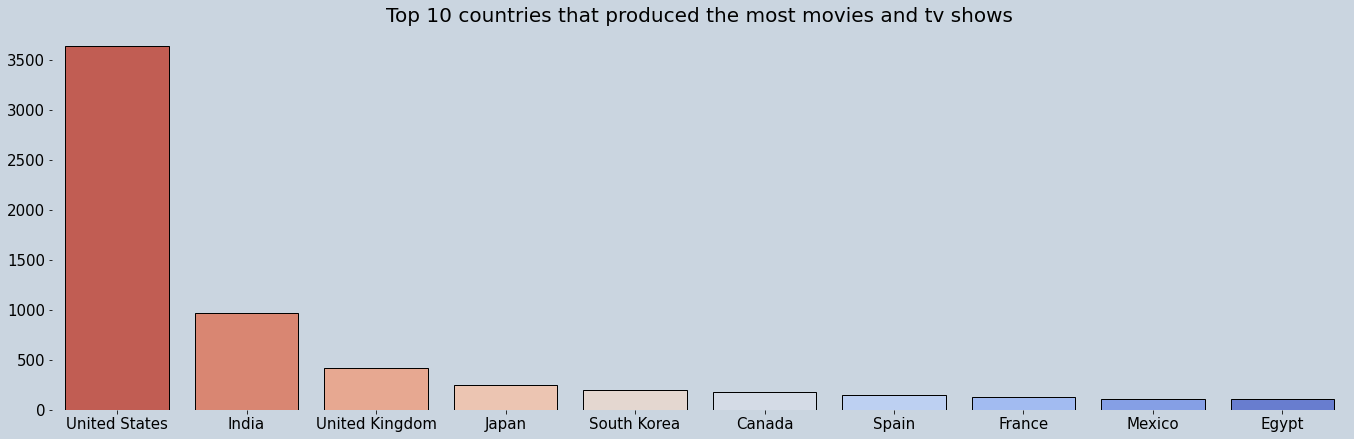

In [29]:
fig = plt.figure(figsize =(20, 7))
fig.patch.set_facecolor('#CAD5E0')

df_country_top10 = pd.DataFrame({'Country': countries, 'Count': country_top10.values})

sns.barplot(data = df_country_top10, x = 'Country', y = 'Count' ,palette='coolwarm_r', edgecolor='black')
plot_design()
plt.title('Top 10 countries that produced the most movies and tv shows', fontsize=20)

In [30]:
print(f"Najviše filmova i TV emisija je proizvedeno u {countries[0]} - {country_top10.values[0]}. \r\nDruga država po redu je {countries[1]} - {country_top10.values[1]} i na trećem mjestu je {countries[2]} - {country_top10.values[2]}.")

Najviše filmova i TV emisija je proizvedeno u United States - 3638. 
Druga država po redu je India - 972 i na trećem mjestu je United Kingdom - 418.


In [31]:
movie_country_top10 = data_movie['country'].value_counts()[:10]
movie_countries = np.array(movie_country_top10.index)

Text(0.5, 1.0, 'Top 10 countries that produced the most movies')

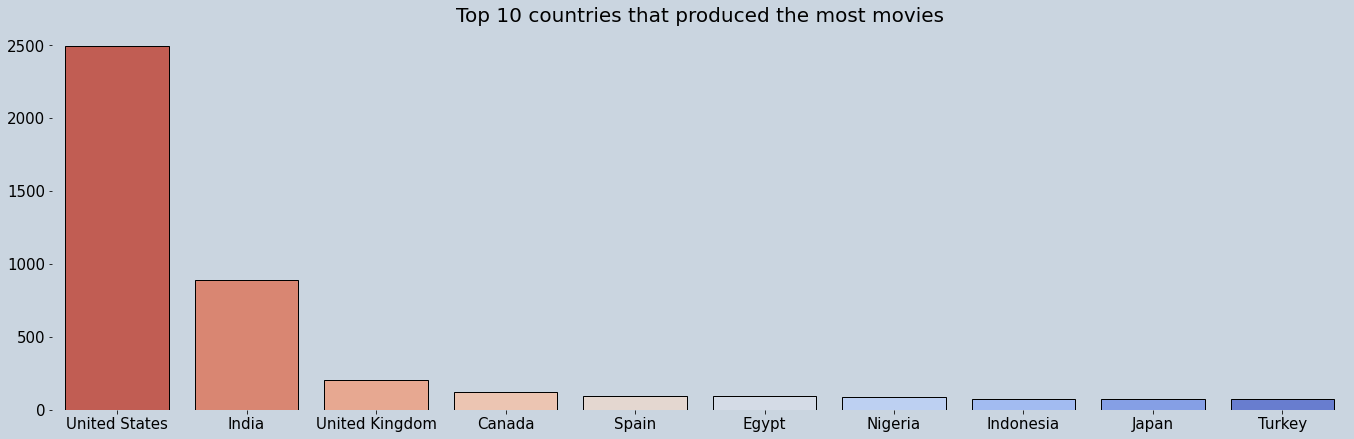

In [32]:
fig = plt.figure(figsize =(20, 7))
fig.patch.set_facecolor('#CAD5E0')

df_movie_country_top10 = pd.DataFrame({'Country': movie_countries, 'Count': movie_country_top10.values})

sns.barplot(data = df_movie_country_top10, x = 'Country', y = 'Count' ,palette='coolwarm_r', edgecolor='black')
plot_design()
plt.title('Top 10 countries that produced the most movies', fontsize=20)

In [33]:
print(f"Države u kojima je proizvedeno najviše filmova su istog poretka kao i u općenitoj analizi: \r\n 1. {movie_countries[0]} - {movie_country_top10.values[0]}\r\n 2. {movie_countries[1]} - {movie_country_top10.values[1]}\r\n 3. {movie_countries[2]} - {movie_country_top10.values[2]}")

Države u kojima je proizvedeno najviše filmova su istog poretka kao i u općenitoj analizi: 
 1. United States - 2494
 2. India - 893
 3. United Kingdom - 206


In [34]:
TVshow_country_top10 = data_TVshow['country'].value_counts()[:10]
TVshow_countries = np.array(TVshow_country_top10.index)

Text(0.5, 1.0, 'Top 10 countries that produced the most TV shows')

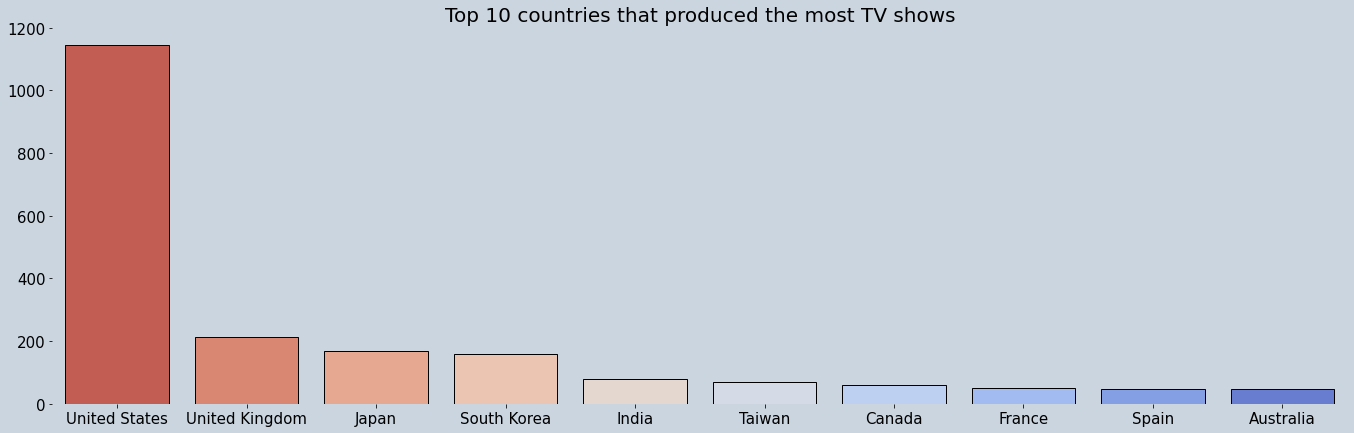

In [35]:
fig = plt.figure(figsize =(20, 7))
fig.patch.set_facecolor('#CAD5E0')

df_TVshow_country_top10 = pd.DataFrame({'Country': TVshow_countries, 'Count': TVshow_country_top10.values})

sns.barplot(data = df_TVshow_country_top10, x = 'Country', y = 'Count' ,palette='coolwarm_r', edgecolor='black')
plot_design()
plt.title('Top 10 countries that produced the most TV shows', fontsize=20)

In [36]:
print(f"Najviše TV emisija je proizvedeno u: \r\n 1. {TVshow_countries[0]} - {TVshow_country_top10.values[0]}\r\n 2. {TVshow_countries[1]} - {TVshow_country_top10.values[1]}\r\n 3. {TVshow_countries[2]} - {TVshow_country_top10.values[2]}")

Najviše TV emisija je proizvedeno u: 
 1. United States - 1144
 2. United Kingdom - 212
 3. Japan - 167


### **Broj filmova i TV emisija po godinama dodavanja na Netflix:**

In [37]:
year_added = data['date_added'].dt.strftime('%Y')

In [38]:
new_data = data.assign(year_added = year_added)

In [127]:
new_data

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unkown,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",United States,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unkown,United States,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,2019-11-20,2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...",2019
8803,s8804,TV Show,Zombie Dumb,Unknown,Unkown,United States,2019-07-01,2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...",2019
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,2019-11-01,2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,2019
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,2020-01-11,2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",2020


Text(0.5, 1.0, 'Number of movies and TV shows added to Netflix each year')

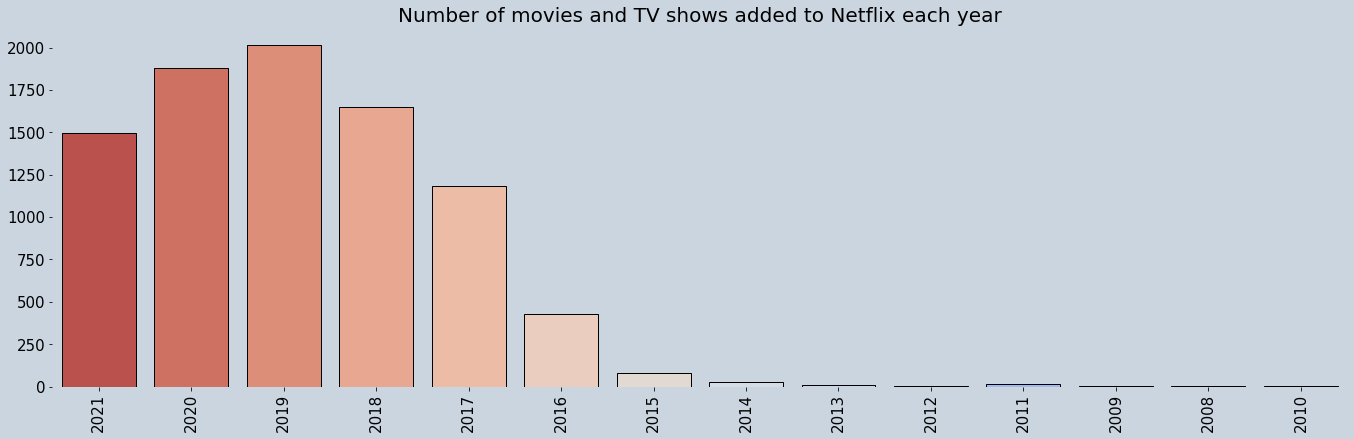

In [39]:
fig = plt.figure(figsize =(20, 7))
fig.patch.set_facecolor('#CAD5E0')

sns.countplot(x = new_data['year_added'], palette='coolwarm_r', edgecolor='black')
plt.xticks(rotation = 90)
plot_design()
plt.title('Number of movies and TV shows added to Netflix each year', fontsize=20)

In [40]:
print(f"Najviše novog sadržaja na Netflix je dodano {new_data['year_added'].value_counts().idxmax()}. godine.\r\nTo je logično budući da je te godine započela svjetska pandemija pa su korisnici imali više vremena za gledanje Netflixa.\r\nDodano je čak {new_data['year_added'].value_counts().max()} novih naslova.")

Najviše novog sadržaja na Netflix je dodano 2019. godine.
To je logično budući da je te godine započela svjetska pandemija pa su korisnici imali više vremena za gledanje Netflixa.
Dodano je čak 2016 novih naslova.


In [41]:
new_data_group_type = new_data.groupby('type')
new_data_movie = new_data_group_type.get_group('Movie')
new_data_TVshow = new_data_group_type.get_group('TV Show')

Text(0.5, 1.0, 'Number of movies added to Netflix each year')

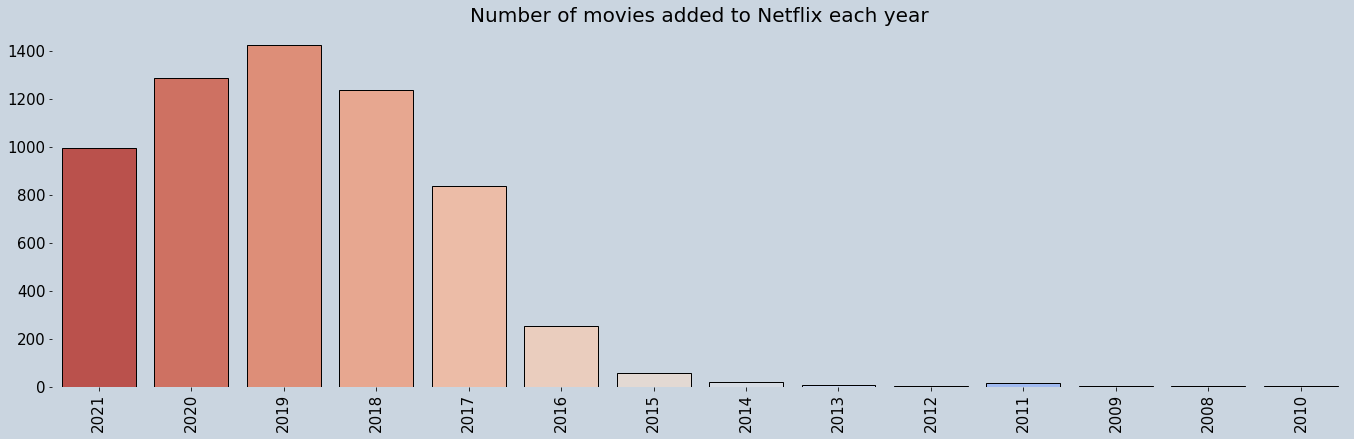

In [42]:
fig = plt.figure(figsize =(20, 7))
fig.patch.set_facecolor('#CAD5E0')

sns.countplot(x = new_data_movie['year_added'], data = new_data_movie,  palette='coolwarm_r', edgecolor='black')
plt.xticks(rotation = 90)
plot_design()
plt.title('Number of movies added to Netflix each year', fontsize=20)

In [43]:
print(f"{new_data_movie['year_added'].value_counts().idxmax()}. su dodana {new_data_movie['year_added'].value_counts().max()} nova filma.")

2019. su dodana 1424 nova filma.


Text(0.5, 1.0, 'Number of TV shows added to Netflix each year')

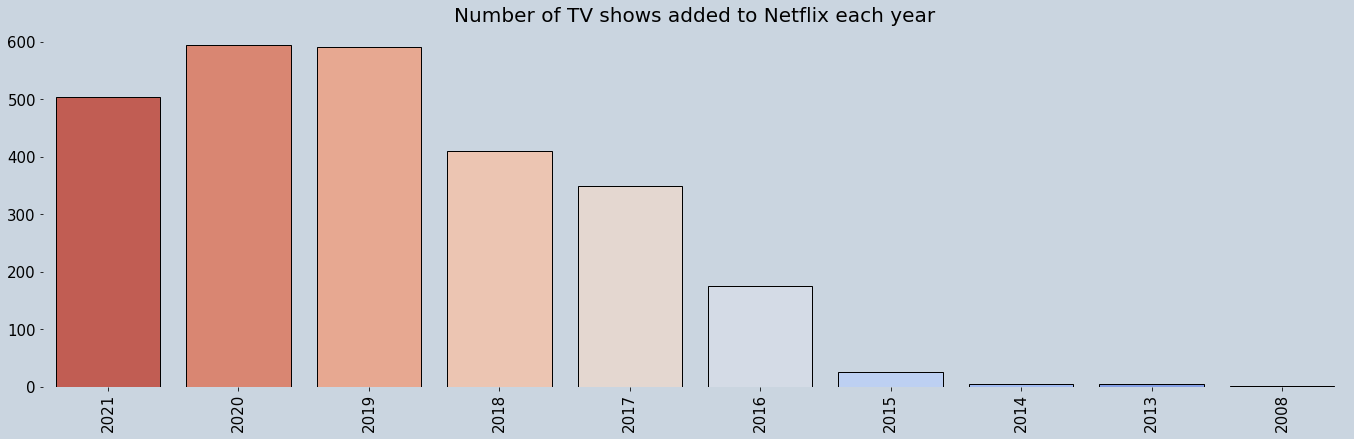

In [44]:
fig = plt.figure(figsize =(20, 7))
fig.patch.set_facecolor('#CAD5E0')

sns.countplot(x = new_data_TVshow['year_added'], data = new_data_TVshow,  palette='coolwarm_r', edgecolor='black')
plt.xticks(rotation = 90)
plot_design()
plt.title('Number of TV shows added to Netflix each year', fontsize=20)

In [45]:
print(f"{new_data_TVshow['year_added'].value_counts().idxmax()}. je dodano najviše TV emisija sa {new_data_TVshow['year_added'].value_counts().max()} novih naslova.")

2020. je dodano najviše TV emisija sa 595 novih naslova.


### **Najpopularniji žanrovi među filmovima i TV emisijama:**

In [46]:
genres_top10 = data['listed_in'].value_counts()[:10]
genres = np.array(genres_top10.index)

Text(0.5, 1.0, 'Top 10 genres')

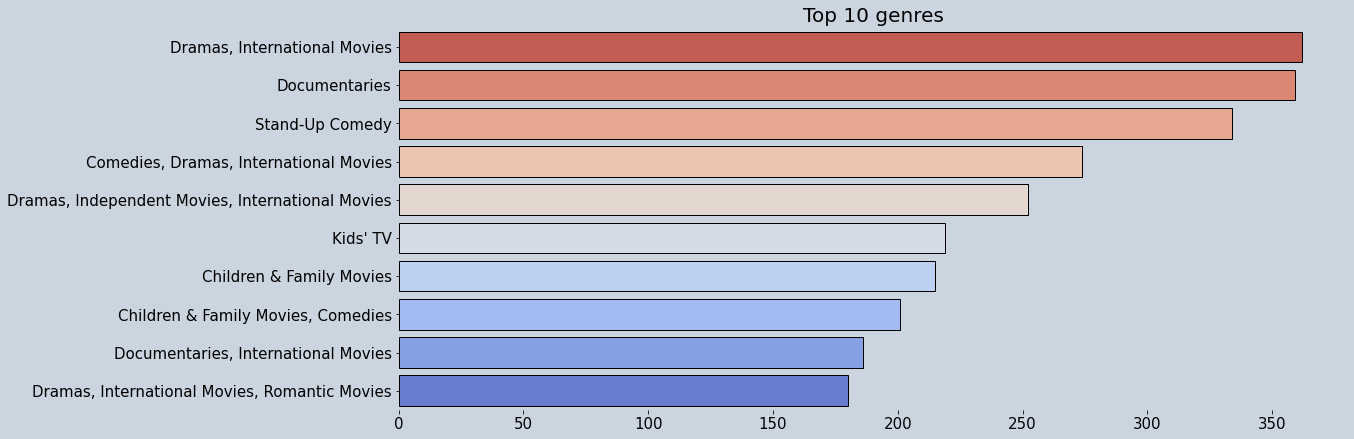

In [47]:
fig = plt.figure(figsize =(20, 7))
fig.patch.set_facecolor('#CAD5E0')

df_genres_top10 = pd.DataFrame({'Genre': genres, 'Count': genres_top10.values})

sns.barplot(data = df_genres_top10, y = 'Genre', x = 'Count', palette='coolwarm_r', edgecolor='black')
plot_design()
plt.title('Top 10 genres', fontsize=20)

In [48]:
print(f"Najpopularniji žanr među filmovima i TV emisijama je {genres[0]}, a iza njega je {genres[1]}.")

Najpopularniji žanr među filmovima i TV emisijama je Dramas, International Movies, a iza njega je Documentaries.


In [49]:
movie_genres_top10 = data_movie['listed_in'].value_counts()[:10]
movie_genres = np.array(movie_genres_top10.index)

Text(0.5, 1.0, 'Top 10 movie genres')

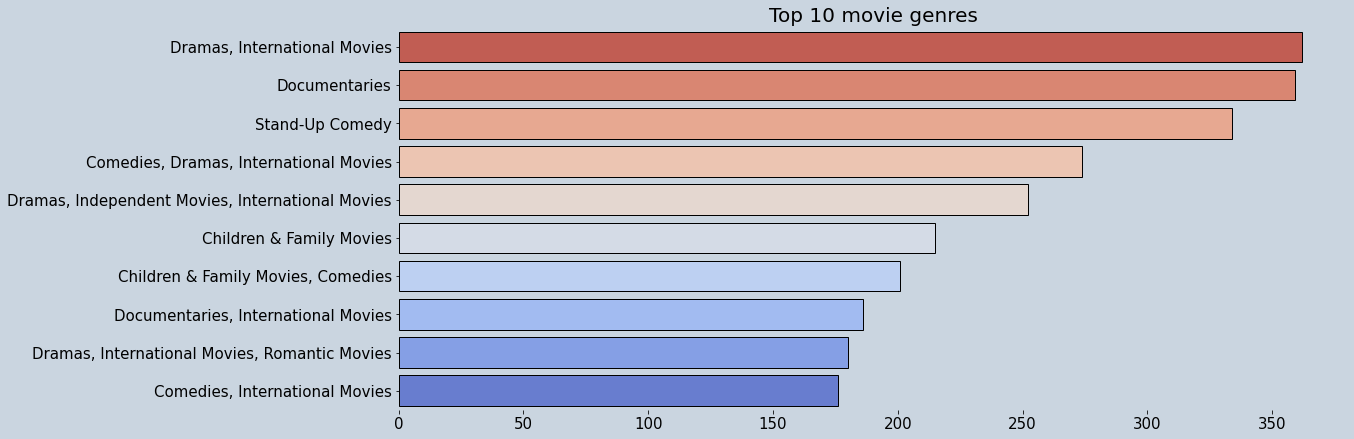

In [50]:
fig = plt.figure(figsize =(20, 7))
fig.patch.set_facecolor('#CAD5E0')

df_movie_genres_top10 = pd.DataFrame({'Genre': movie_genres, 'Count': movie_genres_top10.values})

sns.barplot(data = df_movie_genres_top10, y = 'Genre', x = 'Count' ,palette='coolwarm_r', edgecolor='black')
plot_design()
plt.title('Top 10 movie genres', fontsize=20)

In [51]:
print(f"Najpopularniji filmski žanr je {movie_genres[0]}.")

Najpopularniji filmski žanr je Dramas, International Movies.


In [52]:
TVshow_genres_top10 = data_TVshow['listed_in'].value_counts()[:10]
TVshow_genres = np.array(TVshow_genres_top10.index)

Text(0.5, 1.0, 'Top 10 genres of TV shows')

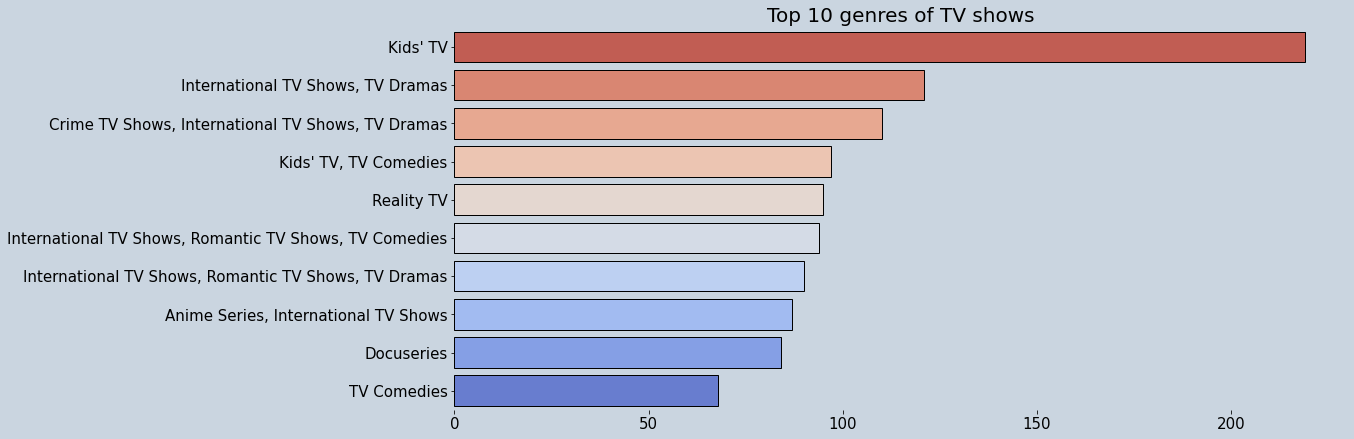

In [53]:
fig = plt.figure(figsize =(20, 7))
fig.patch.set_facecolor('#CAD5E0')

df_TVshow_genres_top10 = pd.DataFrame({'Genre': TVshow_genres, 'Count': TVshow_genres_top10.values})

sns.barplot(data = df_TVshow_genres_top10, y = 'Genre', x = 'Count' ,palette='coolwarm_r', edgecolor='black')
plot_design()
plt.title('Top 10 genres of TV shows', fontsize=20)

In [54]:
print(f"Najzastupljeniji žanr među TV emisijama je {TVshow_genres[0]}.")

Najzastupljeniji žanr među TV emisijama je Kids' TV.


### **Najpopularniji redatelji:**

In [55]:
directors_top10 = data['director'].value_counts()[1:10]

Text(0.5, 1.0, 'Top 10 directors')

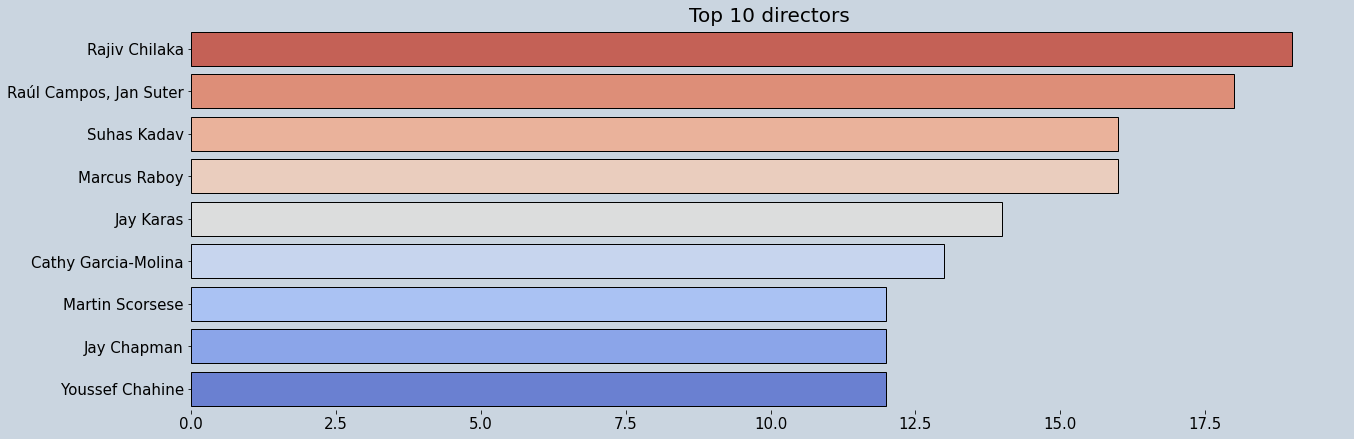

In [56]:
fig = plt.figure(figsize =(20, 7))
fig.patch.set_facecolor('#CAD5E0')

df_directors_top10 = pd.DataFrame({'Director': directors_top10.index, 'Count': directors_top10.values})

sns.barplot(data = df_directors_top10, y = 'Director', x = 'Count', palette='coolwarm_r', edgecolor='black')
plot_design()
plt.title('Top 10 directors', fontsize=20)

In [57]:
print(f"3 najpopularnija redatelja filmova i TV emisija:\r\n 1. {directors_top10.index[0]} - {directors_top10.values[0]} \r\n 2. {directors_top10.index[1]} - {directors_top10.values[1]} \r\n 3. {directors_top10.index[2]} - {directors_top10.values[2]}")

3 najpopularnija redatelja filmova i TV emisija:
 1. Rajiv Chilaka - 19 
 2. Raúl Campos, Jan Suter - 18 
 3. Suhas Kadav - 16


In [58]:
movie_directors_top10 = data_movie['director'].value_counts()[1:10]
TVshow_directors_top10 = data_TVshow['director'].value_counts()[1:10]

Text(0.5, 1.0, 'Top 10 movie directors')

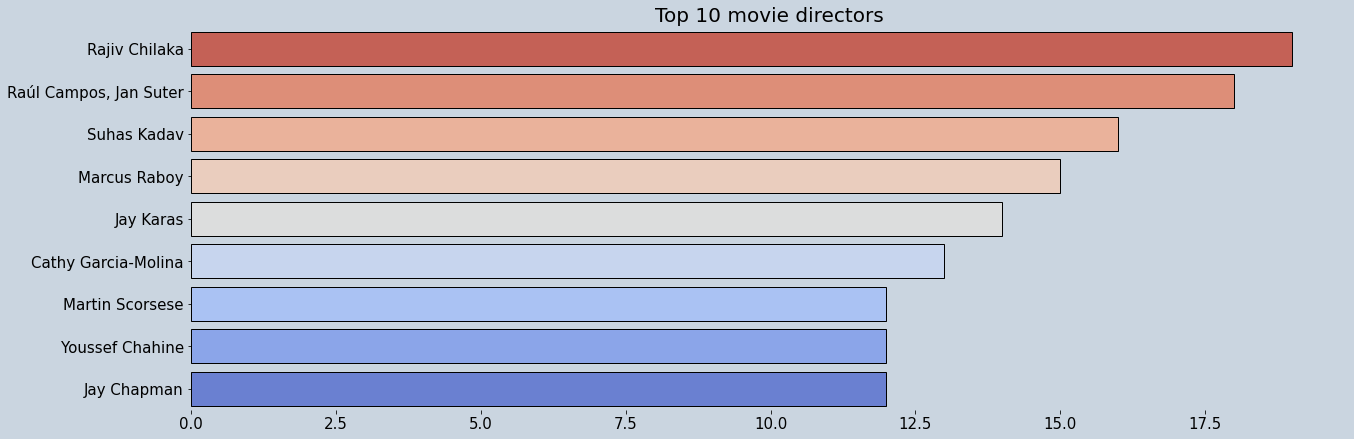

In [59]:
fig = plt.figure(figsize =(20, 7))
fig.patch.set_facecolor('#CAD5E0')

df_movie_directors_top10 = pd.DataFrame({'Director': movie_directors_top10.index, 'Count': movie_directors_top10.values})

sns.barplot(data = df_movie_directors_top10, y = 'Director', x = 'Count' ,palette='coolwarm_r', edgecolor='black')
plot_design()
plt.title('Top 10 movie directors', fontsize=20)

In [60]:
print(f"Redatelj koji je režirao najviše filmova je {movie_directors_top10.index[0]} sa režiranih {movie_directors_top10.values[0]} filmova.")

Redatelj koji je režirao najviše filmova je Rajiv Chilaka sa režiranih 19 filmova.


Text(0.5, 1.0, 'Top 10 TV show directors')

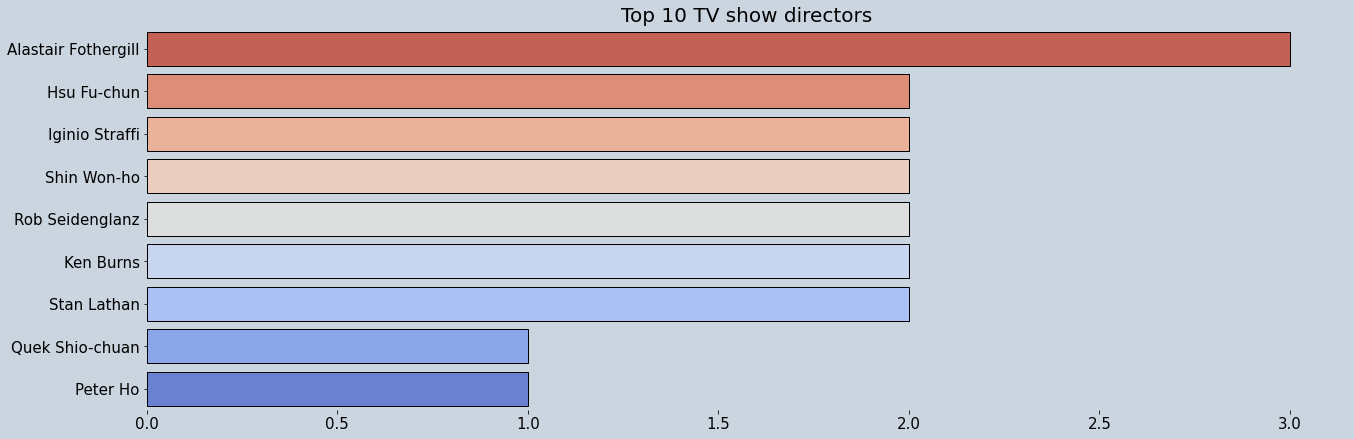

In [61]:
fig = plt.figure(figsize =(20, 7))
fig.patch.set_facecolor('#CAD5E0')

df_TVshow_directors_top10 = pd.DataFrame({'Director': TVshow_directors_top10.index, 'Count': TVshow_directors_top10.values})

sns.barplot(data = df_TVshow_directors_top10, y = 'Director', x = 'Count' ,palette='coolwarm_r', edgecolor='black')
plot_design()
plt.title('Top 10 TV show directors', fontsize=20)

In [62]:
print(f"Najpopularniji redatelj TV emisija je {TVshow_directors_top10.index[0]} koji je režisirao {TVshow_directors_top10.values[0]} TV emisije.")

Najpopularniji redatelj TV emisija je Alastair Fothergill koji je režisirao 3 TV emisije.


### **Najpopularniji redatelji u najpopularnijim žanrovima:**

In [63]:
data_top5genres = data[(data.listed_in == genres[0]) | (data.listed_in == genres[1]) | (data.listed_in == genres[2]) | (data.listed_in == genres[3]) | (data.listed_in == genres[4])]

In [64]:
data_top5genres[['listed_in', 'director']].value_counts()

listed_in        director              
Stand-Up Comedy  Unknown                   25
Documentaries    Unknown                   25
Stand-Up Comedy  Raúl Campos, Jan Suter    18
                 Marcus Raboy              15
                 Jay Karas                 13
                                           ..
Documentaries    Maya Gallus                1
                 Matthew Cooke              1
                 Matt Wechsler              1
                 Matt Tyrnauer              1
Stand-Up Comedy  Yoo Byung-jae              1
Length: 1285, dtype: int64

In [65]:
print("Najpopularniji redatelj u najpopularnijim žanrovima:")
print(f" 1. {genres[0]} - Hanung Bramantyo \r\n 2. {genres[1]} - Edward Cotterill  \r\n 3. {genres[2]} - Raúl Campos, Jan Suter  \r\n 4. {genres[3]} - Cathy Garcia-Molina \r\n 5. {genres[4]} - Onir")

Najpopularniji redatelj u najpopularnijim žanrovima:
 1. Dramas, International Movies - Hanung Bramantyo 
 2. Documentaries - Edward Cotterill  
 3. Stand-Up Comedy - Raúl Campos, Jan Suter  
 4. Comedies, Dramas, International Movies - Cathy Garcia-Molina 
 5. Dramas, Independent Movies, International Movies - Onir


### **Srednja duljina trajanja filma:**

In [66]:
data['duration'] = data['duration'].apply(lambda x: x.replace("min", "") if "min" in x else x)

In [67]:
new_data_groupby = data.groupby('type')
new_data_movie = new_data_groupby.get_group('Movie')

In [68]:
time = []
for t in range(len(data_movie)):
  z = new_data_movie['duration'].iloc[t]
  time.append(int(z))

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


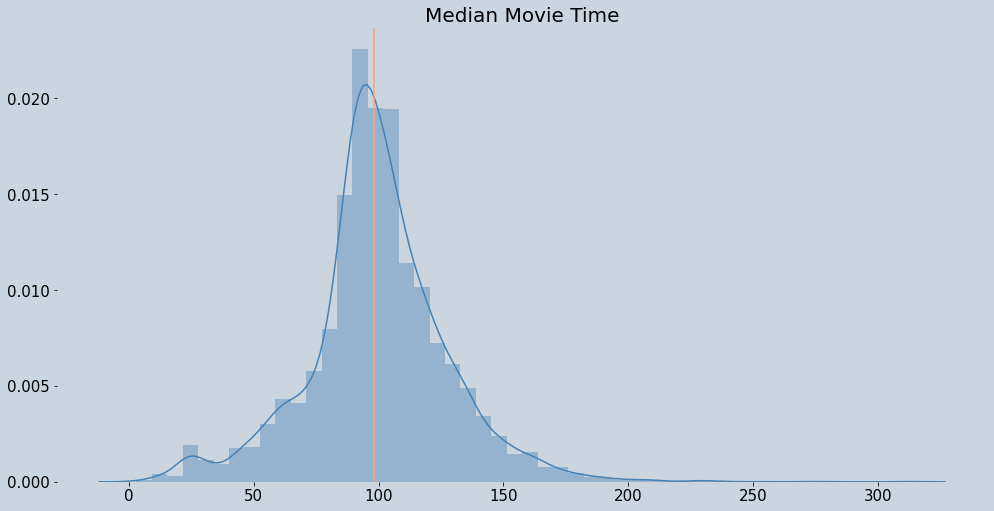

In [69]:
fig = plt.figure(figsize =(15, 8))
fig.patch.set_facecolor('#CAD5E0')

sns.distplot(time, color = 'steelblue');
plot_design()
plt.axvline(statistics.median(time), color='lightsalmon')
plt.title('Median Movie Time', fontsize=20);

Podaci su gotovo normalno distribuirani.

In [70]:
print(f'Najkraći film: {min(time)} min')
print(f'Srednja duljina filma: {statistics.median(time)} min')
print(f'Najduži film: {max(time)} min')

Najkraći film: 3 min
Srednja duljina filma: 98.0 min
Najduži film: 312 min


### **Najčešće riječi u opisu radnje:**

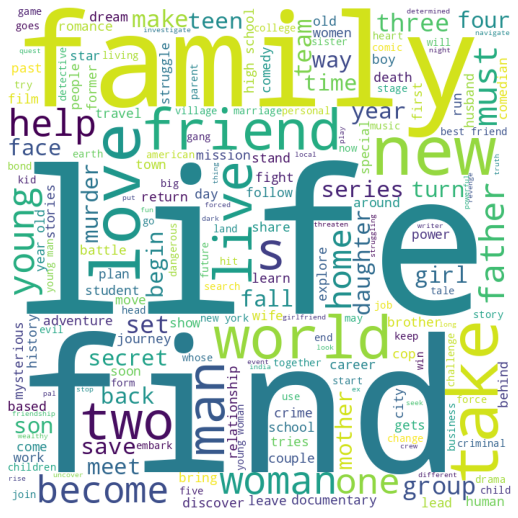

In [71]:
comment_words = ''
stopwords = set(STOPWORDS)

for val in data['description'].values:
    
    val = str(val)

    tokens = val.split()
    
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 700, height = 700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
                 
plt.figure(figsize = (15,7))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

Neke od najčešćih riječi u sažetom opisu: find, life, family, love, new.

## **Statistička značajnost:**

### **Primjer 1:**

Usporedba srednjih duljina trajanja filmova objavljenih u 2017. i 2018. godini.

In [80]:
data_movie_2017 = new_data_movie[new_data_movie.release_year == 2017]
data_movie_2018 = new_data_movie[new_data_movie.release_year == 2018]

In [86]:
time_2017 = []
for t in range(len(data_movie_2017)):
  z = new_data_movie['duration'].iloc[t]
  time_2017.append(int(z))

In [87]:
time_2018 = []
for t in range(len(data_movie_2018)):
  z = new_data_movie['duration'].iloc[t]
  time_2018.append(int(z))

Distribucije:

<AxesSubplot:title={'center':'Duljine trajanja filmova objavljenih 2018. godine'}, xlabel='Duljina trajanja filma', ylabel='Density'>

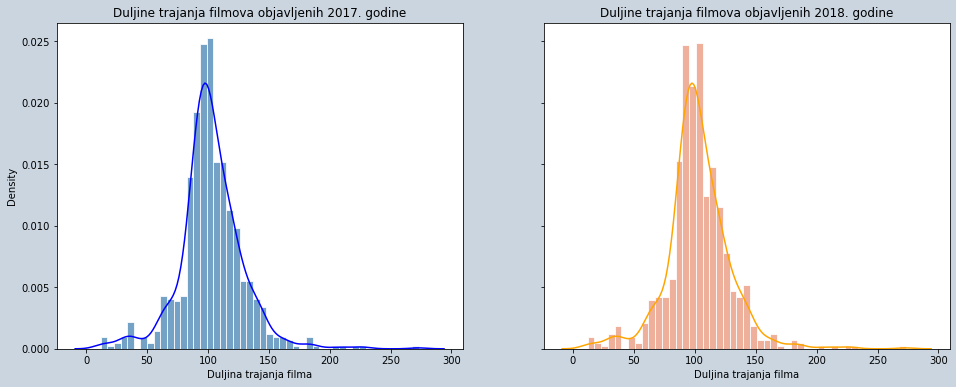

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.patch.set_facecolor('#CAD5E0')

axes[0].set_title('Duljine trajanja filmova objavljenih 2017. godine')
axes[0].set_xlabel("Duljina trajanja filma")
sns.histplot(time_2017, stat = 'density', color = 'steelblue', edgecolor = 'white', ax=axes[0]);
sns.kdeplot(time_2017,  color='blue', ax=axes[0])
axes[1].set_title('Duljine trajanja filmova objavljenih 2018. godine')
axes[1].set_xlabel("Duljina trajanja filma")
sns.histplot(time_2018, stat = 'density', color = 'darksalmon', edgecolor = 'white', ax=axes[1]);
sns.kdeplot(time_2018,  color='orange', ax=axes[1])

Procjenitelji očekivane duljine trajana filma i standarna devijacija:

In [120]:
print(f'2017. godina: mean = {statistics.mean(time_2017):.2f}, std = {np.std(time_2017):.2f}')
print(f'2018. godina: mean = {statistics.mean(time_2018):.2f}, std = {np.std(time_2018):.2f}')

2017. godina: mean = 102.76, std = 26.31
2018. godina: mean = 102.72, std = 26.29


**Određivanje hipoteza:**
<br><br>
**$H_0$: Srednja duljina trajanja filma je jednaka u 2017. godini i 2018. godini.** <br>
$\left(H_0:  \mu_{2017} =\mu_{2018}\right)$

**$H_1:$ Srednja duljina trajanja filma u 2017. godini i 2018. godini je različita.**<br>
$\left(H_1:  \mu_{2017} \neq\mu_{2018}\right)$

**Određivanje kriterija za odluku:**

**$\alpha$ = 0.05**


**Računanje testne statistike:**<br><br> Za računanje testne statistike odabiremo parametarski *Studentov t-test*. Koristimo ga kada uspoređujemo srednje vrijednosti dviju grupa. Pretpostavke parametarskog testa su da su podaci približno normalno distribuirani i da imaju slične varijance. <br> Za početak ćemo provjeriti jesu li srednje duljine trajanja filmova normalno distribuirane.

Hipoteze:
> * $H_0$: podaci su normalno distribuirani
> * $H_1$: podaci nisu normalno distribuirani

Razina značajnosti:
> * $\alpha = 0.05$.

<AxesSubplot:title={'center':'Duljine trajanja filmova objavljenih 2018. godine'}, xlabel='Duljina trajanja filma', ylabel='Density'>

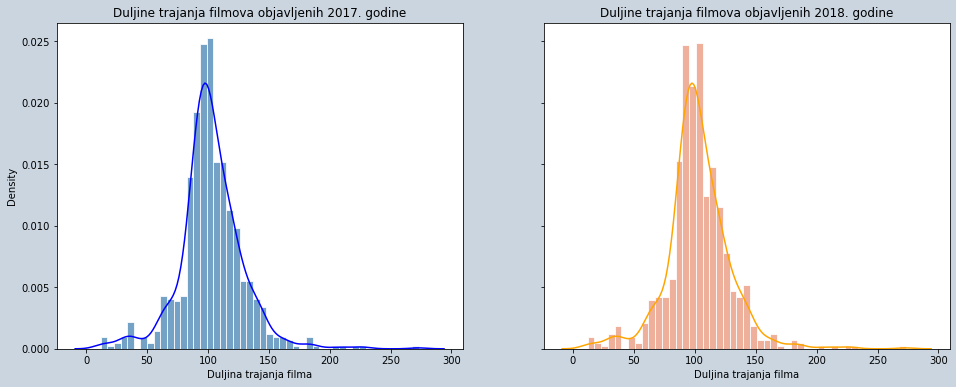

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.patch.set_facecolor('#CAD5E0')

axes[0].set_title('Duljine trajanja filmova objavljenih 2017. godine')
axes[0].set_xlabel("Duljina trajanja filma")
sns.histplot(time_2017, stat = 'density', color = 'steelblue', edgecolor = 'white', ax=axes[0]);
sns.kdeplot(time_2017,  color='blue', ax=axes[0])
axes[1].set_title('Duljine trajanja filmova objavljenih 2018. godine')
axes[1].set_xlabel("Duljina trajanja filma")
sns.histplot(time_2018, stat = 'density', color = 'darksalmon', edgecolor = 'white', ax=axes[1]);
sns.kdeplot(time_2018,  color='orange', ax=axes[1])

In [122]:
statistic, pvalue = stats.normaltest(time_2017)
print(f"pvalue: {pvalue}")
print(f"pvalue < 0.05: {pvalue < 0.05}")

pvalue: 6.87130116923526e-28
pvalue < 0.05: True


In [123]:
statistic, pvalue = stats.normaltest(time_2018)
print(f"pvalue: {pvalue}")
print(f"pvalue < 0.05: {pvalue < 0.05}")

pvalue: 4.3693913645915565e-28
pvalue < 0.05: True


P-vrijednost je manja od 0.05, stoga odbacujemo $H_0$, odnosno duljine trajanja filmova nisu normalno distribuirane niti za 2017. niti za 2018. godinu.

S obzirom da podaci ne prate normalnu distribuciju, dalje odabiremo neparametarski test. Odabiremo *Mann-Whitney U test*, koji je neparametarski ekvivalent studentovom t-testu.

In [124]:
statistic, pvalue = stats.mannwhitneyu(time_2017, time_2018)
print(f"pvalue: {pvalue}")
print(f"pvalue < 0.05: {pvalue < 0.05}")

pvalue: 0.9550894440317669
pvalue < 0.05: False


**Donošenje odluke:**


P-vrijednost je veća od 0.05 i samim time ne odbacujemo $H_0$. <br>
**Zaključak**: Srednja duljina trajanja filma je jednaka u 2017. godini i 2018. godini.

### **Primjer 2:**

Usporedba broja dodanog sadržaja u prvoj polovici 2019. godine i u drugoj polovici godine, budući da je to godina s najviše dodanog novog sadržaja na Netflix.

In [161]:
data_f6m = data.loc[(data['date_added'] >= '2019-01-01') & (data['date_added'] < '2019-07-01')]

In [162]:
data_f6m_ = data_f6m['date_added'].value_counts()

In [163]:
data_s6m = data.loc[(data['date_added'] >= '2019-07-01') & (data['date_added'] < '2020-01-01')]

In [164]:
data_s6m_ = data_s6m['date_added'].value_counts()

Distribucija:

<AxesSubplot:title={'center':'Broj dodanog sadržaja u drugih 6 mjeseci 2019. god.'}, xlabel='Broj dodavanja', ylabel='Density'>

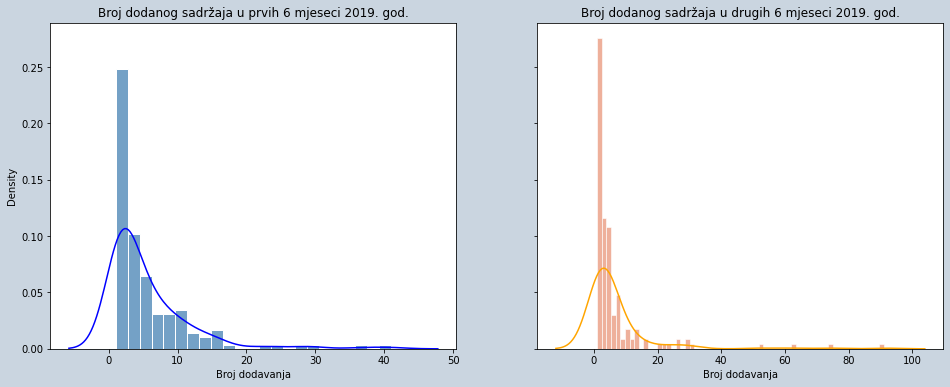

In [165]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.patch.set_facecolor('#CAD5E0')

axes[0].set_title('Broj dodanog sadržaja u prvih 6 mjeseci 2019. god.')
axes[0].set_xlabel("Broj dodavanja")
sns.histplot(data_f6m_, stat = 'density', color = 'steelblue', edgecolor = 'white', ax=axes[0]);
sns.kdeplot(data_f6m_, color='blue', ax=axes[0])
axes[1].set_title('Broj dodanog sadržaja u drugih 6 mjeseci 2019. god.')
axes[1].set_xlabel("Broj dodavanja")
sns.histplot(data_s6m_, stat = 'density', color = 'darksalmon', edgecolor = 'white', ax=axes[1]);
sns.kdeplot(data_s6m_, color='orange', ax=axes[1])

Procjenitelji očekivanog broja dodavanja sadržaja i standardna devijacija:

In [166]:
print(f'Prvih 6 mjeseci 2019. godine: mean = {data_f6m_.mean():.2f}, std = {data_f6m_.std():.2f}')
print(f'Drugih 6 mjeseci 2019. godine: mean = {data_s6m_.mean():.2f}, std = {data_s6m_.std():.2f}')

Prvih 6 mjeseci 2019. godine: mean = 5.57, std = 6.30
Drugih 6 mjeseci 2019. godine: mean = 6.71, std = 11.94


**Određivanje hipoteza:**
<br><br>
**$H_0$: Srednja vrijednost broja dnevnog dodavanja sadržaja je jednaka u prvih 6 mjeseci 2019. godine i u drugih 6 mjeseci godine.** <br>
$\left(H_0:  \mu_{1.-6.} =\mu_{7.-12.}\right)$

**$H_1:$ Srednja vrijednost broja dnevnog dodavanja sadržaja je različita u prvih 6 mjeseci 2019. godine i u drugih 6 mjeseci godine..**<br>
$\left(H_1:  \mu_{1.-6.} \neq\mu_{7.-12.}\right)$

**Određivanje kriterija za odluku:**

**$\alpha$ = 0.05**

**Računanje testne statistike:**

Kao i u prethodnom primjeru odabiremo Studentov t-test.

Provjeravamo jesu li podaci normalno distribuirani:

Hipoteze:
> * $H_0$: podaci su normalno distribuirani
> * $H_1$: podaci nisu normalno distribuirani

Razina značajnosti:
> * $\alpha = 0.05$.

<AxesSubplot:title={'center':'Broj dodanog sadržaja u drugih 6 mjeseci 2019. god.'}, xlabel='Broj dodavanja', ylabel='Density'>

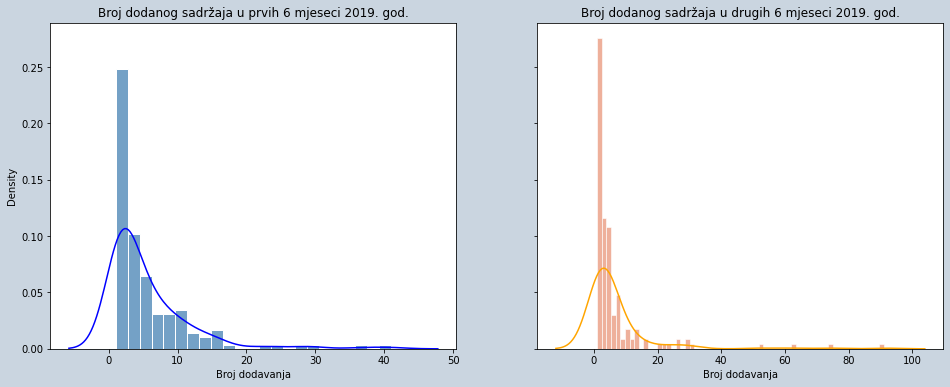

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.patch.set_facecolor('#CAD5E0')

axes[0].set_title('Broj dodanog sadržaja u prvih 6 mjeseci 2019. god.')
axes[0].set_xlabel("Broj dodavanja")
sns.histplot(data_f6m_, stat = 'density', color = 'steelblue', edgecolor = 'white', ax=axes[0]);
sns.kdeplot(data_f6m_, color='blue', ax=axes[0])
axes[1].set_title('Broj dodanog sadržaja u drugih 6 mjeseci 2019. god.')
axes[1].set_xlabel("Broj dodavanja")
sns.histplot(data_s6m_, stat = 'density', color = 'darksalmon', edgecolor = 'white', ax=axes[1]);
sns.kdeplot(data_s6m_, color='orange', ax=axes[1])

In [168]:
statistic, pvalue = stats.normaltest(data_f6m_)
print(f"pvalue: {pvalue}")
print(f"pvalue < 0.05: {pvalue < 0.05}")

pvalue: 6.124271906257093e-28
pvalue < 0.05: True


In [169]:
statistic, pvalue = stats.normaltest(data_s6m_)
print(f"pvalue: {pvalue}")
print(f"pvalue < 0.05: {pvalue < 0.05}")

pvalue: 1.7397445902535472e-40
pvalue < 0.05: True


P-vrijednost je manja od 0.05 pa odbacujemo $H_0$. 

Budući da podaci ne prate normalnu distribuciju, odabiremo Mann-Whitney U neparametarski test.

In [170]:
statistic, pvalue = stats.mannwhitneyu(data_f6m_, data_s6m_)
print(f"pvalue: {pvalue}")
print(f"pvalue < 0.05: {pvalue < 0.05}")

pvalue: 0.6588482548525496
pvalue < 0.05: False


**Donošenje odluke:**


P-vrijednost je veća od 0.05 i time ne odbacujemo $H_0$. <br>
**Zaključak**: Srednja vrijednost broja dnevnog dodavanja sadržaja je jednaka u prvih 6 mjeseci 2019. godine i u drugih 6 mjeseci godine.

## **Grupiranje podataka:**

Na početku ćemo definirati na temelju kojih atributa želimo grupirati filmove i TV emisije. <br> 
Odabrani atributi:
*   director
*   cast
*   country
*   listed_in
*   description

Uklonit ćemo sve ne-ASCII znakove, stop riječi, interpukcijske znakove i pretvorit sve tekstualne podatke u mala slova. <br>
Napravit ćemo lematizaciju za grupiranje različitih oblika iste riječi, tokenizaciju i vektorizaciju. Vekorizacija riječi pretvara pojedinačne riječi u vektore za jednostavno korištenje i razumijevanje pomoću algoritma strojnog učenja.



### **Priprema podataka:**

Korištenje originalnog skupa podataka za klasteriranje:

In [ ]:
data_original = pd.read_csv('netflix_titles.csv')

In [ ]:
data_copy = data_original.copy()

In [ ]:
data_copy.fillna('', inplace = True)

Kombiniranje svih atributa klasteriranja u jedan stupac:

In [ ]:
data_copy['clustering_atributes'] = (data_copy['director'] + ' ' + data_copy['cast'] + ' ' + data_copy['country'] + ' ' + data_copy['listed_in'] + ' ' + data_copy['description'])

In [ ]:
data_copy['clustering_atributes'][92]

' Pauline Etienne, Laurent Capelluto, Stefano Cassetti, Mehmet Kurtuluş, Babetida Sadjo, Jan Bijvoet, Ksawery Szlenkier, Vincent Londez, Regina Bikkinina, Alba Gaïa Kraghede Bellugi, Nabil Mallat Belgium International TV Shows, TV Dramas, TV Mysteries Passengers and crew aboard a hijacked overnight flight scramble to outrace the sun as a mysterious cosmic event wreaks havoc on the world below.'

##### **Uklanjanje znakova koji nisu ASCII:**

In [ ]:
def remove_non_ascii(words):
  new_words = []
  for word in words:
    new_word = unicodedata.normalize('NFKD', word).encode ('ascii', 'ignore').decode('utf-8', 'ignore')
    new_words.append(new_word)
  return new_words

In [ ]:
data_copy['clustering_atributes'] = remove_non_ascii(data_copy['clustering_atributes'])

In [ ]:
data_copy['clustering_atributes'][92]

' Pauline Etienne, Laurent Capelluto, Stefano Cassetti, Mehmet Kurtulus, Babetida Sadjo, Jan Bijvoet, Ksawery Szlenkier, Vincent Londez, Regina Bikkinina, Alba Gaia Kraghede Bellugi, Nabil Mallat Belgium International TV Shows, TV Dramas, TV Mysteries Passengers and crew aboard a hijacked overnight flight scramble to outrace the sun as a mysterious cosmic event wreaks havoc on the world below.'

##### **Uklanjanje stop riječi i mijenjanje ostalih riječi u mala slova:**

In [ ]:
sw = stopwords.words('english')

In [ ]:
def stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    return " ".join(text)

In [ ]:
data_copy['clustering_atributes'] = data_copy['clustering_atributes'].apply(stopwords)

In [ ]:
data_copy['clustering_atributes'][92]

'pauline etienne, laurent capelluto, stefano cassetti, mehmet kurtulus, babetida sadjo, jan bijvoet, ksawery szlenkier, vincent londez, regina bikkinina, alba gaia kraghede bellugi, nabil mallat belgium international tv shows, tv dramas, tv mysteries passengers crew aboard hijacked overnight flight scramble outrace sun mysterious cosmic event wreaks havoc world below.'

##### **Uklanjanje interpukcijskih znakova:**

In [ ]:
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [ ]:
data_copy['clustering_atributes'] = data_copy['clustering_atributes'].apply(remove_punctuation)

In [ ]:
data_copy['clustering_atributes'][92]

'pauline etienne laurent capelluto stefano cassetti mehmet kurtulus babetida sadjo jan bijvoet ksawery szlenkier vincent londez regina bikkinina alba gaia kraghede bellugi nabil mallat belgium international tv shows tv dramas tv mysteries passengers crew aboard hijacked overnight flight scramble outrace sun mysterious cosmic event wreaks havoc world below'

##### **Lematizacija:**

In [ ]:
def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [ ]:
data_copy['clustering_atributes'] = lemmatize_verbs(data_copy['clustering_atributes'])

In [ ]:
data_copy['clustering_atributes'][92]

'pauline etienne laurent capelluto stefano cassetti mehmet kurtulus babetida sadjo jan bijvoet ksawery szlenkier vincent londez regina bikkinina alba gaia kraghede bellugi nabil mallat belgium international tv shows tv dramas tv mysteries passengers crew aboard hijacked overnight flight scramble outrace sun mysterious cosmic event wreaks havoc world below'

##### **Tokenizacija:**

In [ ]:
tokenizer = TweetTokenizer()

In [ ]:
data_copy['clustering_atributes'] = data_copy['clustering_atributes'].apply(lambda x: tokenizer.tokenize(x))

##### **Vektorizacija:**

In [ ]:
clustering_data = data_copy['clustering_atributes']

In [ ]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False, max_features = 20000)    
X = tfidf.fit_transform(clustering_data)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


In [ ]:
X

<8807x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 266239 stored elements in Compressed Sparse Row format>

In [ ]:
X.shape

(8807, 20000)

In [ ]:
type(X)

scipy.sparse.csr.csr_matrix

In [ ]:
X = X.toarray()

##### **Smanjenje dimenzionalnosti:**

Koristimo PCA kako bismo smanjili dimenzionalnost podataka.

In [ ]:
pca = PCA(random_state=42)
pca.fit(X)

PCA(random_state=42)

Text(0, 0.5, 'cumulative explained variance')

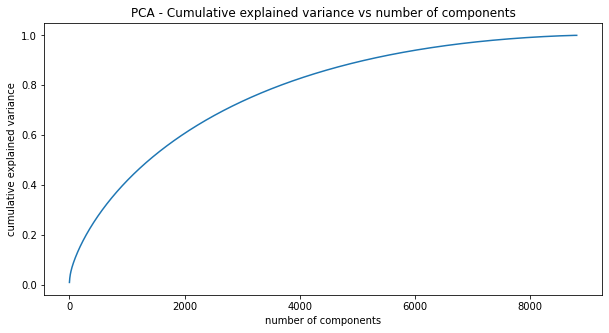

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA - Cumulative explained variance vs number of components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

4000 komponenti može obuhvatiti više od 80% varijance, stoga broj komponenti ograničavamo na 4000.

In [ ]:
pca = PCA(n_components=4000,random_state=42)
pca.fit(X)

PCA(n_components=4000, random_state=42)

In [ ]:
x_pca = pca.transform(X)

In [ ]:
x_pca.shape

(8807, 4000)

#### **K-means:**

Za grupiranje podataka koristimo K-means algoritam klasteriranja. Koristimo poboljšanu verziju K-means algoritma, a to je K-means++ algoritam. Jedina razlika je inicijalizacija centroida na početku algoritma. U K-means++ odabiremo početne centroide pomoću algoritma koji pokušava inicijalizirati centroide koji su daleko jedan od drugoga. Što su klasteri udaljeniji, to je bolje.


Metodom 'elbow curve' pronalazimo optimalan broj klastera za grupiranje. Radi po principu pronalaženja WCSS-a (zbroj kvadrata unutar klastera), tj. zbroja kvadrata udaljenosti između točaka u klasteru i središta klastera. Ponekad nije baš jasno prepoznati točan K korištenjem metode 'elbow curve'. 'Silhouette score' vrlo je korisna metoda za pronalaženje broja K. Vrijednost se kreće od -1 do 1.

Text(0, 0.5, 'WCSS')

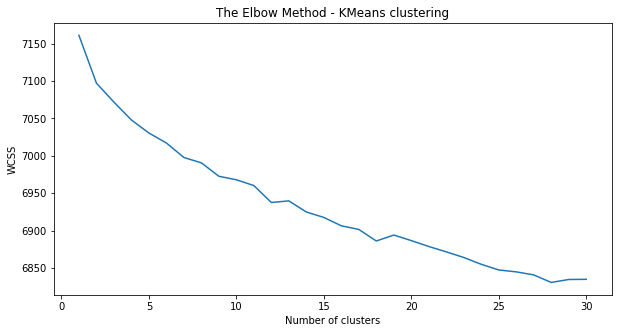

In [ ]:
wcss=[]
for i in range(1,31):
  kmeans = KMeans(n_clusters=i,init='k-means++',random_state=33)
  kmeans.fit(x_pca)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,31)
plt.figure(figsize=(10,5))
plt.plot(number_clusters,wcss)
plt.title('The Elbow Method - KMeans clustering')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

WCSS se smanjuje povećanjem broja klastera.

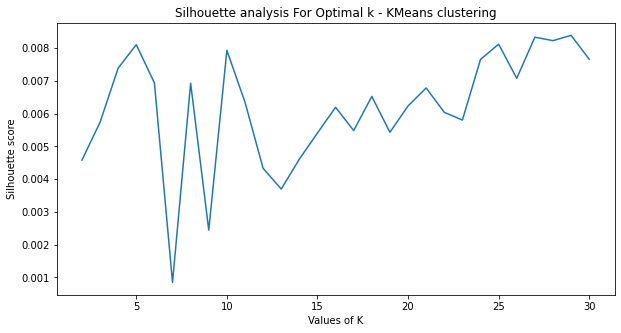

In [ ]:
range_n_clusters = range(2,31)
silhouette_avg = []
for num_clusters in range_n_clusters:

  kmeans = KMeans(n_clusters=num_clusters,init='k-means++',random_state=33)
  kmeans.fit(x_pca)
  cluster_labels = kmeans.labels_
 
  silhouette_avg.append(silhouette_score(x_pca, cluster_labels))

plt.figure(figsize=(10,5))
plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k - KMeans clustering')
plt.show()

Najviša vrijednost 'silhouette score' je za 29 klastera.

In [ ]:
kmeans = KMeans(n_clusters=29,init='k-means++',random_state=33)
kmeans.fit(x_pca)

KMeans(n_clusters=29, random_state=33)

In [ ]:
kmeans_distortion = kmeans.inertia_
kmeans_silhouette_score = silhouette_score(x_pca, kmeans.labels_)

print((kmeans_distortion,kmeans_silhouette_score))

(6834.672118076788, 0.008392087076959289)


'Silhouette_score' približan 0 označava da je uzorak na ili vrlo blizu granice odluke između dva susjedna klastera.

In [ ]:
data_copy['kmeans_cluster'] = kmeans.labels_

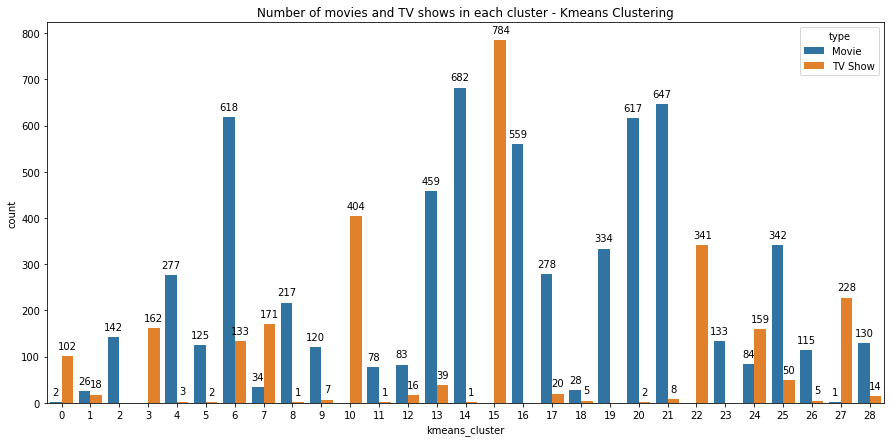

In [ ]:
plt.figure(figsize=(15,7))
q = sns.countplot(x = 'kmeans_cluster', data = data_copy, hue='type')
plt.title('Number of movies and TV shows in each cluster - Kmeans Clustering')

for i in q.patches:
  q.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

##### **Wordclouds za klastere:**

In [ ]:
def kmeans_worldcloud(cluster_num):
  comment_words = ''
  stopwords = set(STOPWORDS)

  for val in data_copy[data_copy['kmeans_cluster'] == cluster_num].description.values:

    val = str(val)

    tokens = val.split()

    for i in range(len(tokens)):
      tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens) + ""

  wordcloud = WordCloud(width = 700, height = 700,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)

  plt.figure(figsize = (10,5), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

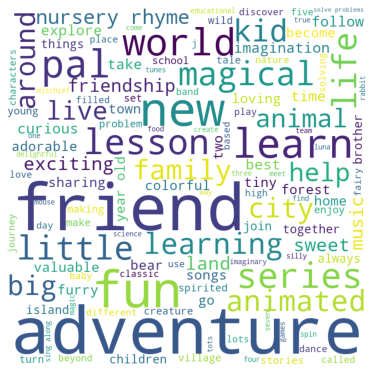

In [ ]:
kmeans_worldcloud(0)

Ključne riječi za prvi klaster: adventure, friend, fun, new, learn...

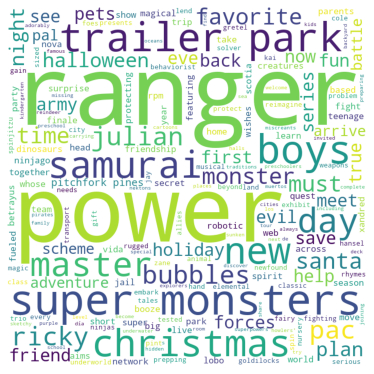

In [ ]:
kmeans_worldcloud(1)

Ključne riječi za drugi klaster: power, ranger, monsters, christmas, trailer...

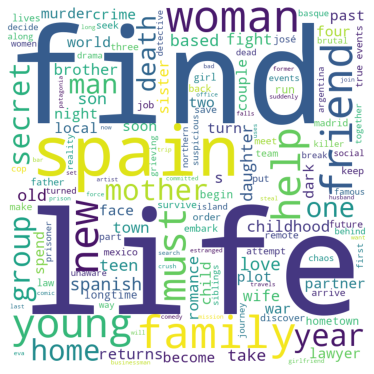

In [ ]:
kmeans_worldcloud(2)

Ključne riječi za treći klaster: find, life, spain, woman, family...

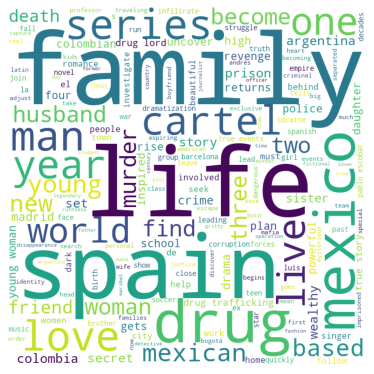

In [ ]:
kmeans_worldcloud(3)

Ključne riječi za četvrti klaster: family, life, mexico, drug, cartel...

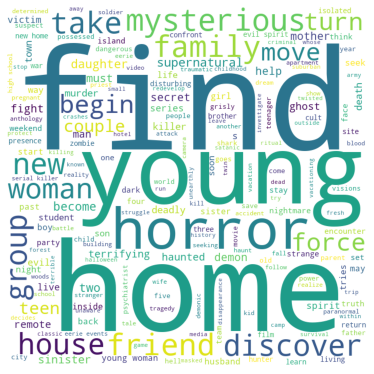

In [ ]:
kmeans_worldcloud(4)

Ključne riječi za peti klaster: find, young, home, horrror, discover...